# Librerias a utilizar

In [4]:
#Importing all necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, dates
import seaborn as sns 


from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV, cross_validate
import xgboost as xg
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.metrics import mean_squared_error

# Importar datasets

In [5]:
new_df_mesos = pd.read_csv('../DATASETS/new_df_mesos.csv').set_index('month_year')
new_df_dies = pd.read_csv('../DATASETS/new_df_dies.csv').set_index('CMPLNT_FR_DT')
community_mesos = pd.read_csv('../DATASETS/community_mesos.csv').set_index('month_year')
community_dies = pd.read_csv('../DATASETS/community_dies.csv').set_index('CMPLNT_FR_DT')


df_filtered = pd.read_csv('../DATASETS/df_filtered.csv')
df = pd.read_csv('../DATASETS/df_crimes.csv')

/var/folders/1d/_xylp1812vd2jg38vsf_30w00000gn/T/ipykernel_970/3222150152.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df_filtered = pd.read_csv('../DATASETS/df_filtered.csv')
/var/folders/1d/_xylp1812vd2jg38vsf_30w00000gn/T/ipykernel_970/3222150152.py:8: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../DATASETS/df_crimes.csv')


# FUNCION PARA DIVIDIR TRAIN Y TEST

In [9]:
def split_data(data,X,y,test_size,district):
    idx_train, idx_test = train_test_split(data.index, test_size=test_size, shuffle=False)
    if district == True:
        X_train, y_train = X.loc[idx_train.unique(), :], X.loc[idx_test.unique(), :]
        X_test, y_test = y.loc[idx_train.unique()], y.loc[idx_test.unique()]
    else:
        X_train, y_train = X.loc[idx_train, :], X.loc[idx_test, :]
        X_test, y_test = y.loc[idx_train], y.loc[idx_test]
    
    return X_train, y_train, X_test, y_test

# PREDICT: VERANO 2018

In [12]:
new_df_dies.index = pd.to_datetime(new_df_dies.index)
df_all_days = new_df_dies.loc[new_df_dies.index.year >=2015]
df_all_days = df_all_days[df_all_days.index < '2018-09-01'].copy()
df_all_days = df_all_days.drop(columns=['cos(1,freq=A-DEC)'])

In [13]:
df_all_days

,Agressions,New Years,agressions_lag_1,agressions_lag_2,agressions_lag_3,agressions_lag_4,agressions_week_avg,agressions_biweek_avg,agressions_1_month_avg,agressions_2_month_avg,...,"cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",Poverty,Unemployment,Bachelor_or_higher
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2018-01-01,160.0,1,18.0,12.0,15.0,13.0,35.142857,25.928571,22.033333,21.783333,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.192,0.078,0.321
2018-01-02,15.0,0,160.0,18.0,12.0,15.0,34.428571,25.500000,21.900000,21.683333,...,0.918958,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,0.192,0.078,0.321
2018-01-03,8.0,0,15.0,160.0,18.0,12.0,34.428571,25.214286,21.466667,21.600000,...,0.688967,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.192,0.078,0.321
2018-01-04,10.0,0,8.0,15.0,160.0,18.0,34.000000,25.071429,21.033333,21.450000,...,0.347305,0.433884,-0.900969,-0.781831,0.623490,0.974928,-0.222521,0.192,0.078,0.321
2018-01-05,16.0,0,10.0,8.0,15.0,160.0,34.142857,24.928571,21.066667,21.400000,...,-0.050649,-0.433884,-0.900969,0.781831,0.623490,-0.974928,-0.222521,0.192,0.078,0.321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27,24.0,0,22.0,30.0,19.0,24.0,22.571429,22.500000,23.866667,24.583333,...,-0.440394,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.192,0.078,0.321
2018-08-28,16.0,0,24.0,22.0,30.0,19.0,22.285714,22.142857,23.433333,24.516667,...,-0.050649,0.781831,0.623490,0.974928,-0.222521,0.433884,-0.900969,0.192,0.078,0.321
2018-08-29,22.0,0,16.0,24.0,22.0,30.0,22.428571,22.428571,23.633333,24.433333,...,0.347305,0.974928,-0.222521,-0.433884,-0.900969,-0.781831,0.623490,0.192,0.078,0.321


In [19]:
X = df_all_days.drop(columns = ['Agressions', 'New Years'])
y = df_all_days['Agressions']
X_train, X_test, y_train, y_test  = split_data(y, X, y, 61,False)

model = xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0) 
model.fit(X_train, y_train) 
xg_pred_train_y = model.predict(X_train) 
xg_pred_test_y = model.predict(X_test)


test = y_test.to_frame()
test['Pred']  = xg_pred_test_y
test['Agressions'] = test.iloc[-4697:].values
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

,Agressions,Pred,Mean model,MAPE,MAPE mean,SMAPE,SMAPE mean,MAE,MAE mean,Metrica nomb,Metrica nomb mean,RMSE,RMSE mean,MSE
CMPLNT_FR_DT,,,,,,,,,,,,,,
2018-07-02,20.0,36.899231,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506
2018-07-03,25.0,37.318207,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506
2018-07-04,29.0,37.437160,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506
2018-07-05,26.0,35.438885,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506
2018-07-06,24.0,36.032814,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-27,24.0,34.289265,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506
2018-08-28,16.0,34.700207,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506
2018-08-29,22.0,34.399788,23.47541,61.687256,20.738455,44.484512,15.275514,12.571189,4.842247,100.0,54.098361,13.406696,7.843984,179.739506


In [20]:
train = y_train.to_frame()
train['Pred']  = xg_pred_train_y
d = pd.concat([train.reset_index().set_index(['CMPLNT_FR_DT','Agressions', 'Pred']), test.reset_index().set_index(['CMPLNT_FR_DT','Agressions', 'Pred'])], axis=1, join = 'outer')
d = d.reset_index().iloc[:,:-12]
d = d.set_index('CMPLNT_FR_DT')
d = d[-30:]

dies_ver = pd.DataFrame()
dies_ver = d[['Agressions', 'Pred']]
dies_ver = dies_ver.rename(columns={'Pred':'XGBoost'})

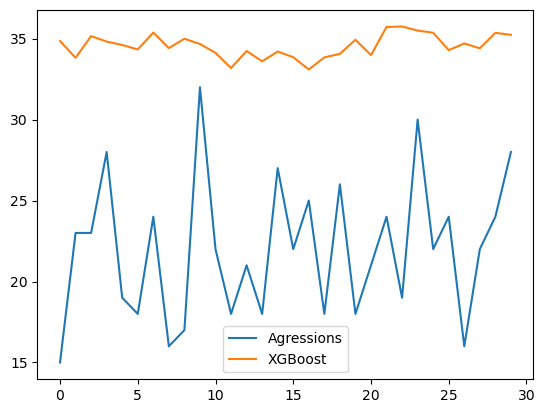

In [21]:
dies_ver = dies_ver.reset_index()
dies_ver.plot(y=["Agressions","XGBoost"])
plt.show()

In [22]:
pred_ver = test[['Agressions', 'Pred']]
pred_ver = pred_ver.rename(columns={'Pred':'XGBoost'})

In [23]:
pred_ver

,Agressions,XGBoost
CMPLNT_FR_DT,,
2018-07-02,20.0,36.899231
2018-07-03,25.0,37.318207
2018-07-04,29.0,37.437160
2018-07-05,26.0,35.438885
2018-07-06,24.0,36.032814
...,...,...
2018-08-27,24.0,34.289265
2018-08-28,16.0,34.700207
2018-08-29,22.0,34.399788


In [24]:
pred_ver.to_csv('../DATASETS/pred_models_verano_2018.csv')

# PREDICT: VERANO POR COMUNIDAD 2010

In [41]:
community_dies = community_dies[community_dies.index < '2010-08-31'].copy()

In [45]:
boro_mapping = {'BRONX': 1, 'BROOKLYN': 2, 'MANHATTAN': 3, 'QUEENS': 4, 'STATEN ISLAND': 5}

community_dies['BORO_NM'] = community_dies['BORO_NM'].map(boro_mapping)


In [46]:
community_dies

,BORO_NM,Agressions,New Years,agressions_lag_1,agressions_lag_2,agressions_lag_3,agressions_lag_4,agressions_community_1_month_avg,agressions_community_2_month_avg,month,...,"cos(2,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","sin(3,freq=W-SUN)","cos(3,freq=W-SUN)",Poverty,Unemployment,Bachelor_or_higher
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2000-01-01,1,15,1.0,0.0,0.0,1.0,0.0,0.700000,0.716667,1,...,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,0.307,0.143,0.146
2000-01-01,2,24,1.0,1.0,2.0,0.0,0.0,1.166667,1.100000,1,...,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,0.251,0.107,0.218
2000-01-01,3,11,1.0,0.0,0.0,0.0,0.0,0.666667,0.683333,1,...,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,0.199,0.084,0.494
2000-01-01,4,18,1.0,0.0,1.0,0.0,1.0,1.133333,0.966667,1,...,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,0.146,0.077,0.243
2000-01-01,5,5,1.0,0.0,1.0,0.0,0.0,0.333333,0.233333,1,...,1.000000,-0.974928,-0.222521,0.433884,-0.900969,0.781831,0.62349,0.100,0.059,0.232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-08-30,1,2,NaN,4.0,2.0,5.0,6.0,3.000000,3.133333,8,...,0.688967,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.291,0.118,0.164
2010-08-30,2,3,NaN,6.0,6.0,5.0,2.0,5.366667,5.750000,8,...,0.688967,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.226,0.074,0.279
2010-08-30,3,5,NaN,3.0,5.0,6.0,6.0,5.033333,4.750000,8,...,0.688967,0.000000,1.000000,0.000000,1.000000,0.000000,1.00000,0.183,0.067,0.552


In [48]:
#XGBoost
X= community_dies.drop(columns = 'Agressions')
y = community_dies['Agressions']

X_train, X_test, y_train, y_test  = split_data(y, X, y,305,True)
model= xg.XGBRegressor(n_estimators=500, learning_rate = 0.01, max_depth= 3, subsample = 0.5, colsample_bytree = 0.4, colsample_bylevel = 1, random_state=0)
model.fit(X_train, y_train) 
rf_pred_train_y = model.predict(X_train) 
rf_pred_test_y = model.predict(X_test)

y_test = y_test.to_frame()
test = y_test


test['Agressions'] = test.iloc[-305:].values

test['Pred'] = rf_pred_test_y
test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Mean model']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])
test

,Agressions,Pred,Mean model,MAPE,MAPE mean,SMAPE,SMAPE mean,MAE,MAE mean,Metrica nomb,Metrica nomb mean,RMSE,RMSE mean,MSE
CMPLNT_FR_DT,,,,,,,,,,,,,,
2010-07-01,10,10.243906,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712
2010-07-01,25,18.530033,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712
2010-07-01,10,11.254179,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712
2010-07-01,11,13.022561,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712
2010-07-01,2,3.051909,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-08-30,2,3.074260,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712
2010-08-30,3,5.439734,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712
2010-08-30,5,4.611109,3.852459,inf,inf,62.279473,70.685688,1.522922,2.358613,57.04918,51.803279,1.964106,3.032264,3.857712


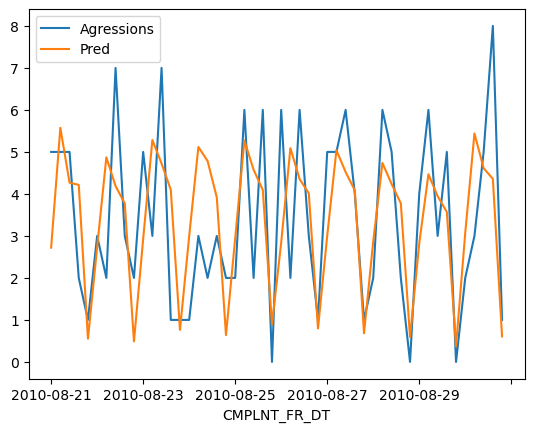

In [55]:
test_filter1 = test[-50:]
test_filter = test
test_filter1.plot(y=["Agressions","Pred"])
plt.show()

In [58]:
pred_com_ver_10 = test_filter[['Agressions', 'Pred']]
pred_com_ver_10 = pred_com_ver_10.rename(columns={'Pred':'XGBoost'})

In [59]:
pred_com_ver_10

,Agressions,XGBoost
CMPLNT_FR_DT,,
2010-07-01,10,10.243906
2010-07-01,25,18.530033
2010-07-01,10,11.254179
2010-07-01,11,13.022561
2010-07-01,2,3.051909
...,...,...
2010-08-30,2,3.074260
2010-08-30,3,5.439734
2010-08-30,5,4.611109


In [60]:
pred_com_ver_10.to_csv('../DATASETS/pred_models_com_ver_2010.csv')

# PREDICT: ANY 2010

In [6]:
df_mesos = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
#df_mesos = df_mesos[df_mesos.index < '2007-01']

In [7]:
df_mesos

,Agressions,New Years,agressions_lag_3,agressions_lag_4,month,primavera,estiu,tardor,hivern,year_1966,...,"cos(1,freq=M)","sin(1,freq=W-SUN)","cos(1,freq=W-SUN)","sin(2,freq=W-SUN)","cos(2,freq=W-SUN)","cos(3,freq=W-SUN)","sin(4,freq=W-SUN)",Poverty,Unemployment,Bachelor_or_higher
month_year,,,,,,,,,,,,,,,,,,,,,
2000-01,78.0,1,5.0,11.0,1,0,0,0,1,False,...,1.0,-0.974928,-0.222521,0.433884,-0.900969,0.623490,-0.781831,0.212,0.096,0.274
2000-02,8.0,0,4.0,5.0,2,0,0,0,1,False,...,1.0,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0.212,0.096,0.274
2000-03,4.0,0,5.0,4.0,3,1,0,0,0,False,...,1.0,0.974928,-0.222521,-0.433884,-0.900969,0.623490,0.781831,0.212,0.096,0.274
2000-04,5.0,0,78.0,5.0,4,1,0,0,0,False,...,1.0,-0.974928,-0.222521,0.433884,-0.900969,0.623490,-0.781831,0.212,0.096,0.274
2000-05,4.0,0,8.0,78.0,5,1,0,0,0,False,...,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.212,0.096,0.274
2000-06,17.0,0,4.0,8.0,6,0,1,0,0,False,...,1.0,0.433884,-0.900969,-0.781831,0.623490,-0.222521,-0.974928,0.212,0.096,0.274
2000-07,11.0,0,5.0,4.0,7,0,1,0,0,False,...,1.0,-0.974928,-0.222521,0.433884,-0.900969,0.623490,-0.781831,0.212,0.096,0.274
2000-08,13.0,0,4.0,5.0,8,0,1,0,0,False,...,1.0,0.781831,0.623490,0.974928,-0.222521,-0.900969,-0.433884,0.212,0.096,0.274
2000-09,21.0,0,17.0,4.0,9,0,0,1,0,False,...,1.0,-0.433884,-0.900969,0.781831,0.623490,-0.222521,0.974928,0.212,0.096,0.274


In [10]:
#XGBoost
df_mesos = new_df_mesos.drop(columns = ['agressions_2_month_avg', 'agressions_6_month_avg', 'agressions_lag_1', 'agressions_lag_2', 'trend'])
df_mesos = df_mesos[df_mesos.index < '2011-01']

X= df_mesos.drop(columns = 'Agressions')
y = df_mesos['Agressions']

X_train, X_test, y_train, y_test  = split_data(y, X, y, 12,False)

random_grid = { 'max_depth': [3, 5, 6, 10, 15, 20],
                  'learning_rate': [0.01, 0.1, 0.2, 0.3],
                  'subsample': np.arange(0.5, 1.0, 0.1),
                  'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                  'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                  'n_estimators': [100, 500, 1000]}

model = xg.XGBRegressor(random_state=0)
random_search = RandomizedSearchCV(model, param_distributions=random_grid, scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
xg_pred_train = random_search.predict(X_train) 
xg_pred_test = random_search.predict(X_test)

print(random_search.best_estimator_)
print(random_search.best_params_)

test = y_test.to_frame()
test['Agressions'] = test.iloc[-12:].values
test['Pred']  = xg_pred_test

test['Mean model'] = test['Agressions'].mean()
test['MAPE'] = np.mean(np.abs((test['Agressions'] - test['Pred'])/test['Agressions']))*100
test['MAPE mean'] = np.mean(np.abs((test['Agressions'] - test['Mean model'])/test['Agressions']))*100
test['SMAPE'] = np.mean(np.abs((test['Pred']-test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['SMAPE mean'] = np.mean(np.abs((test['Mean model'] - test['Agressions'])/((np.abs(test['Pred']) + np.abs(test['Agressions']))/2)))*100
test['MAE'] = np.mean(np.abs(test['Agressions'] - test['Pred']))
test['MAE mean'] = np.mean(np.abs(test['Agressions'] - test['Mean model']))
test['Metrica nomb'] = (test['Agressions'] < test['Pred']).sum()/len(test['Pred'])*100
test['Metrica nomb mean'] = (test['Agressions'] < test['Mean model']).sum()/len(test['Pred'])*100
test['RMSE'] = np.sqrt(mean_squared_error(test['Agressions'], test['Pred']))
test['RMSE mean'] = np.sqrt(mean_squared_error(test['Agressions'], test['Mean model']))
test['MSE'] = mean_squared_error(test['Agressions'], test['Pred'])

test

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.6, colsample_bynode=None, colsample_bytree=0.7,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=0, ...)
{'subsample': 0.8999999999999999, 'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.3, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.6}


,Agressions,Pred,Mean model,MAPE,MAPE mean,SMAPE,SMAPE mean,MAE,MAE mean,Metrica nomb,Metrica nomb mean,RMSE,RMSE mean,MSE
month_year,,,,,,,,,,,,,,
2010-01,719.0,699.246338,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-02,454.0,560.001831,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-03,585.0,566.136475,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-04,561.0,392.500244,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-05,588.0,560.970886,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-06,674.0,580.974304,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-07,612.0,616.259949,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-08,581.0,563.788635,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431
2010-09,596.0,536.884216,579.333333,9.56012,9.228131,9.880557,9.004528,52.591672,50.888889,33.333333,33.333333,69.95273,72.790033,4893.384431


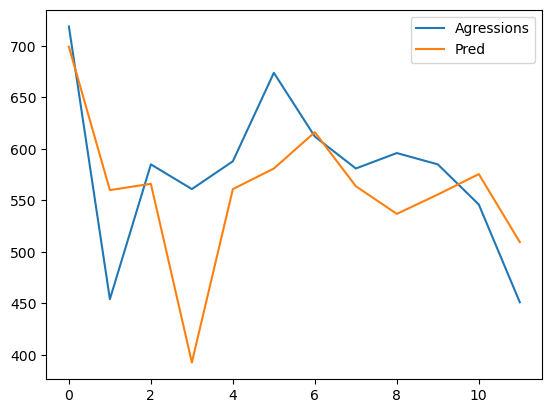

In [11]:
test_filter_months = test.reset_index()
test_filter_months.plot(y=["Agressions","Pred"])
plt.show()

In [12]:
pred_any_06 = test[['Agressions', 'Pred']]
pred_any_06 = pred_any_06.rename(columns={'Pred':'XGBoost'})
pred_any_06

,Agressions,XGBoost
month_year,,
2010-01,719.0,699.246338
2010-02,454.0,560.001831
2010-03,585.0,566.136475
2010-04,561.0,392.500244
2010-05,588.0,560.970886
2010-06,674.0,580.974304
2010-07,612.0,616.259949
2010-08,581.0,563.788635
2010-09,596.0,536.884216


In [13]:
pred_any_06.to_csv('../DATASETS/pred_models_ano_2010.csv')